In [1]:
%run ../../bin/imports.ipynb

In [2]:
import statistics

## Testing performance with lower coverage

Read input data

In [3]:
combined_dash = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/training.pancancer_downsampling.tab',
                          sep='\t')

In [4]:
annotated_loh = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/training.all_data.csv')

In [5]:
total_data = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/pancancer.dash_output.csv')

#### Plotting the overall F1 scores

In [6]:
# Create new dataframe for each depth
depths = [10, 30, 50, 100, 200]
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
depth_dataframes = []
for depth in depths:
    print('Depth:', depth)
    df = pd.DataFrame()
    
    depth_combined_dash = combined_dash[combined_dash['dash_depths'] == depth]
    
    annotated_samples = list(annotated_loh['sample'])
    annotated_genes = list(annotated_loh['gene'])
    annotated_dashs = list(annotated_loh['LOH'])
    
    depth_dash_calls = []
    depth_f1 = []
    output_seeds = []
    annotated_samples_extended = []
    annotated_genes_extended = []
    annotated_dashs_extended = []
    
    for annotated_sample, annotated_gene, annotated_dash in zip(annotated_samples, annotated_genes, annotated_dashs):
        for seed in seeds:
            #print(F"{annotated_sample} {seed}")
            downsampled_subset = depth_combined_dash[(depth_combined_dash['sample'] == annotated_sample) & (depth_combined_dash['genes'] == annotated_gene) &
                                                     (depth_combined_dash['seed'] == seed)]
            dash_calls = list(downsampled_subset['dash_deletions'])

            final_dash_call = False
            if True in dash_calls:
                final_dash_call = True

            f1_value = None
            # check downsampled dash call vs. the annotated dash call for TP, TN, FP, FN
            if final_dash_call and annotated_dash:
                f1_value = "TP"
            elif final_dash_call and not annotated_dash:
                f1_value = "FP"
            elif not final_dash_call and not annotated_dash:
                f1_value = "TN"
            elif not final_dash_call and annotated_dash:
                f1_value = "FN"


            depth_dash_calls.append(final_dash_call)
            depth_f1.append(f1_value)
            output_seeds.append(seed)
            annotated_samples_extended.append(annotated_sample)
            annotated_genes_extended.append(annotated_gene)
            annotated_dashs_extended.append(annotated_dash)
        
    
    df['sample'] = annotated_samples_extended
    df['gene'] = annotated_genes_extended
    df['LOH'] = annotated_dashs_extended
    df['downsampled_dash'] = depth_dash_calls
    df['F1'] = depth_f1
    df['seed'] = output_seeds
    
    depth_dataframes.append(df)


Depth: 10
Depth: 30
Depth: 50
Depth: 100
Depth: 200


In [7]:
def calculate_f1(sensitivity_specificity_df):
    # True positives / True positives + 1/2(False positives + false negatives)
    true_positives = len(sensitivity_specificity_df[sensitivity_specificity_df['F1'] == 'TP'])
    false_positives = len(sensitivity_specificity_df[sensitivity_specificity_df['F1'] == 'FP'])
    false_negatives = len(sensitivity_specificity_df[sensitivity_specificity_df['F1'] == 'FN'])
    
    f1 = true_positives/(true_positives + (.5*(false_positives + false_negatives)))
    return f1

In [8]:
depths = [10, 30, 50, 100, 200]
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
score_df = pd.DataFrame()
for depth_dataframe, depth in zip(depth_dataframes, depths):
    for seed in seeds:
        #print(F"-----Depth: {depth}X Seed: {seed}-----\n")
        depth_dataframe_seed = depth_dataframe[depth_dataframe['seed'] == seed]

        f1 = calculate_f1(depth_dataframe_seed)
        #print(F"F1: {f1}\n")

        temp_df = {'depth': F"{depth}", 'f1': f1}

        score_df = score_df.append(temp_df, ignore_index=True)

In [9]:
# plot as bar graph
score_df_melted = pd.melt(score_df, id_vars=['depth'], value_vars=['f1'])


In [10]:
score_df_melted.head()

,depth,variable,value
0,10,f1,0.114650
1,10,f1,0.112500
2,10,f1,0.139241
3,10,f1,0.150943
4,10,f1,0.161491


In [11]:
score_df_melted.dtypes

depth        object
variable     object
value       float64
dtype: object

In [12]:
# Adding data from full ImmunoID NeXT run
score_df_melted.loc[len(score_df_melted)] = ['587', 'f1', 0.9386281588447654]

In [13]:
score_df_melted.groupby('depth').mean()

,value
depth,
10,0.129267
100,0.881167
200,0.894920
30,0.770039
50,0.854246
587,0.938628


In [14]:
0.938628 - 0.881167

0.057460999999999984

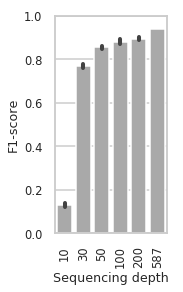

In [15]:
plt.figure(figsize=(2, 4))

sns.set_context('talk', font_scale=0.7)

sns.set_style(style="whitegrid")
g = sns.barplot(x="depth", y='value', hue='variable', data=score_df_melted,
                   order=['10', '30', '50', '100', '200', '587'], palette=['darkgrey'])
plt.legend([],[], frameon=False)

plt.ylabel('F1-score')
plt.xlabel('Sequencing depth')
plt.ylim(0, 1)
plt.xticks(rotation=90)

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/downsampling.f1_scores_barplot.pdf', 
            bbox_inches='tight')

#### Plotting the F1 scores by purity

In [16]:
# using manual annotations
# Create new dataframe for each depth
depths = [10, 30, 50, 100, 200]
purities = [.20, .40, .60, .80, 1.0]
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
depth_dataframes_purities = []
for depth in depths:
    for purity in purities:
        print(F"Depth: {depth}, Purity:{purity}")
        
        df = pd.DataFrame()

        # subset dataframe by depth & by purity
        depth_combined_dash = combined_dash[(combined_dash['dash_depths'] == depth) & (combined_dash['purities'] <= purity)]
        annotated_loh_purity = annotated_loh[annotated_loh['purity'] <= purity]
        
        annotated_samples = list(annotated_loh_purity['sample'])
        annotated_genes = list(annotated_loh_purity['gene'])
        annotated_dashs = list(annotated_loh_purity['LOH'])
        annotated_purities = list(annotated_loh_purity['purity'])

        depth_dash_calls = []
        depth_f1 = []
        annotated_samples_extended = []
        annotated_genes_extended = []
        annotated_dashs_extended = []
        annotated_purities_extended = []
        output_seeds = []
        output_depths = []

        for annotated_sample, annotated_gene, annotated_dash in zip(annotated_samples, annotated_genes, annotated_dashs):
            for seed in seeds:
                downsampled_subset = depth_combined_dash[(depth_combined_dash['sample'] == annotated_sample) & (depth_combined_dash['genes'] == annotated_gene) &
                                                         (depth_combined_dash['seed'] == seed)]
                dash_calls = list(downsampled_subset['dash_deletions'])

                final_dash_call = False
                if True in dash_calls:
                    final_dash_call = True

                f1_value = None
                # check downsampled dash call vs. the annotated dash call for TP, TN, FP, FN
                if final_dash_call and annotated_dash:
                    f1_value = "TP"
                elif final_dash_call and not annotated_dash:
                    f1_value = "FP"
                elif not final_dash_call and not annotated_dash:
                    f1_value = "TN"
                elif not final_dash_call and annotated_dash:
                    f1_value = "FN"


                depth_dash_calls.append(final_dash_call)
                depth_f1.append(f1_value)
                output_seeds.append(seed)
                annotated_samples_extended.append(annotated_sample)
                annotated_genes_extended.append(annotated_gene)
                annotated_dashs_extended.append(annotated_dash)
                annotated_purities_extended.append(purity)
                output_depths.append(depth)


        df['sample'] = annotated_samples_extended
        df['gene'] = annotated_genes_extended
        df['LOH'] = annotated_dashs_extended
        df['purity'] = annotated_purities_extended
        df['downsampled_dash'] = depth_dash_calls
        df['F1'] = depth_f1
        df['seed'] = output_seeds
        df['depth'] = output_depths

        depth_dataframes_purities.append(df)


Depth: 10, Purity:0.2
Depth: 10, Purity:0.4
Depth: 10, Purity:0.6
Depth: 10, Purity:0.8
Depth: 10, Purity:1.0
Depth: 30, Purity:0.2
Depth: 30, Purity:0.4
Depth: 30, Purity:0.6
Depth: 30, Purity:0.8
Depth: 30, Purity:1.0
Depth: 50, Purity:0.2
Depth: 50, Purity:0.4
Depth: 50, Purity:0.6
Depth: 50, Purity:0.8
Depth: 50, Purity:1.0
Depth: 100, Purity:0.2
Depth: 100, Purity:0.4
Depth: 100, Purity:0.6
Depth: 100, Purity:0.8
Depth: 100, Purity:1.0
Depth: 200, Purity:0.2
Depth: 200, Purity:0.4
Depth: 200, Purity:0.6
Depth: 200, Purity:0.8
Depth: 200, Purity:1.0


In [17]:
depths = [10, 30, 50, 100, 200]
purities = [.20, .40, .60, .80, 1]
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
i = 0
score_df_purities = pd.DataFrame()

for depth_dataframe in depth_dataframes_purities:
    purity = depth_dataframe['purity'].iloc[0]
    depth = depth_dataframe['depth'].iloc[0]
    f1 = calculate_f1(depth_dataframe)
    
    temp_df = {'depth': F"{depth}", 'f1': f1, 'purity': purity}

    score_df_purities = score_df_purities.append(temp_df, ignore_index=True)
    

annotated_samples = list(annotated_loh['sample'])
annotated_genes = list(annotated_loh['gene'])
annotated_dashs = list(annotated_loh['LOH'])

total_data_subset = total_data[['hla_locus', 'purity', 'ploidy', 'dash_deletion', 'Sample']]


In [18]:
total_data_subset.head()

,hla_locus,purity,ploidy,dash_deletion,Sample
0,A,0.59,2,False,DNA_S000460823
1,A,0.59,2,False,DNA_S000460823
2,B,0.59,2,False,DNA_S000460823
3,B,0.59,2,False,DNA_S000460823
4,C,0.59,2,False,DNA_S000460823


In [19]:
immunoid_df = pd.DataFrame()

immunoid_dash_output = []
immunoid_purities_output = []

for annotated_sample, annotated_gene, annotated_dash in zip(annotated_samples, annotated_genes, annotated_dashs):
    tmp_df = total_data_subset[(total_data_subset['Sample'] == annotated_sample) & 
                               (total_data_subset['hla_locus'] == annotated_gene)]
    immunoid_dashs = list(tmp_df['dash_deletion'])
    immunoid_dash = False
    if True in immunoid_dashs:
        immunoid_dash = True
    
    immunoid_dash_output.append(immunoid_dash)
    purity = tmp_df['purity'].iloc[0]
    immunoid_purities_output.append(purity)
    
immunoid_df['sample'] = annotated_samples
immunoid_df['gene'] = annotated_genes
immunoid_df['LOH'] = annotated_dashs
immunoid_df['dash_call'] = immunoid_dash_output
immunoid_df['purity'] = immunoid_purities_output

In [20]:
# add f1 column
def add_f1(row):
    f1 = None
    if row['LOH'] == False:
        if row['dash_call'] == True:
            f1 = "FP"
        else:
            f1 = "TN"
    if row['LOH'] == True:
        if row['dash_call'] == True:
            f1 = "TP"
        else:
            f1 = "FN"
    return f1

In [21]:
immunoid_df['F1'] = immunoid_df.apply(lambda row: add_f1(row), axis=1)

In [22]:
immunoid_df.head()

,sample,gene,LOH,dash_call,purity,F1
0,DNA_S000443705,A,False,False,0.64,TN
1,DNA_S000443705,B,False,False,0.64,TN
2,DNA_S000443705,C,False,False,0.64,TN
3,DNA_302298,A,False,False,0.35,TN
4,DNA_302298,C,False,False,0.35,TN


In [23]:
purities = [.20, .40, .60, .80, 1]
immunoid_score_df = pd.DataFrame()
for purity in purities:
    purity_df = immunoid_df[immunoid_df['purity'] <= purity]
    depth = "ImmunoID NeXT"
    # calculate sensitivity/specficity across purities
    f1 = calculate_f1(purity_df)

    #print(F"Sensitivity: {sensitivity}")
    #print(F"Specificity: {specificity}")
    #print(F"F1: {f1}\n")

    temp_df = {'depth': F"{depth}", 'f1': f1, 'purity': purity}

    immunoid_score_df = immunoid_score_df.append(temp_df, ignore_index=True)
    
immunoid_score_df.head()

,depth,f1,purity
0,ImmunoID NeXT,0.757576,0.2
1,ImmunoID NeXT,0.898734,0.4
2,ImmunoID NeXT,0.923077,0.6
3,ImmunoID NeXT,0.930612,0.8
4,ImmunoID NeXT,0.933333,1.0


In [24]:
# Average depth of ImmunoID NeXT: ~600

# update immunoid_df to have mean tumor_Depth as its depth
immunoid_score_df['depth'] = 587
immunoid_score_df.head()

,depth,f1,purity
0,587,0.757576,0.2
1,587,0.898734,0.4
2,587,0.923077,0.6
3,587,0.930612,0.8
4,587,0.933333,1.0


In [25]:
combined_score_df = pd.concat([immunoid_score_df, score_df_purities])
combined_score_df.head()

,depth,f1,purity
0,587,0.757576,0.2
1,587,0.898734,0.4
2,587,0.923077,0.6
3,587,0.930612,0.8
4,587,0.933333,1.0


In [26]:
df = combined_score_df.pivot_table(index='depth', columns='purity', values='f1')
df.index = df.index.astype(int)
df = df.sort_index(ascending=False)
df

purity,0.2,0.4,0.6,0.8,1.0
depth,,,,,
587,0.757576,0.898734,0.923077,0.930612,0.933333
200,0.660274,0.838280,0.874419,0.886680,0.894947
100,0.657497,0.819129,0.859287,0.873849,0.881232
50,0.662404,0.789886,0.829246,0.846790,0.854250
30,0.595420,0.711990,0.738061,0.761243,0.770214
10,0.103837,0.100840,0.101059,0.125000,0.129397


In [27]:
df.columns = [20, 40, 60, 80, 100]

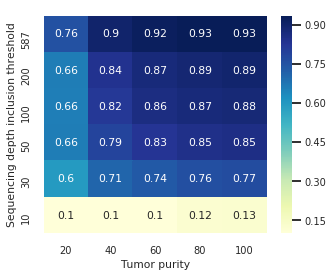

In [28]:
# need to add ImmunoID NeXT & ~600 in illustrator for this image
plt.figure(figsize=(5, 4))
sns.set_context('talk', font_scale=0.6)

sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.xlabel('Tumor purity')
plt.ylabel('Sequencing depth inclusion threshold')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/downsampling.heatmap_by_purity.pdf', 
            bbox_inches='tight')

#### Get the average depths of ImmunoID NeXT and a standard exome

586.4990146501771 568.90842821899


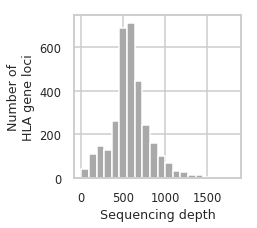

In [29]:
# calculate average depth of immunoid next
run_dir = '/rnd/users/rpyke/data/00-DASH/output/pipeline_nextDB_08'
dash_directories = os.listdir(run_dir)
dash_output_paths = [F'{run_dir}/{dash_directory}' for dash_directory in dash_directories]

# check these paths all exists
for path in dash_output_paths:
    if not os.path.exists(path):
        print(F"Path: {path} doesn't exist")

# grab DASH.all_positions for A B C & calculate the mean depth
normal_depths = []
tumor_depths = []
for dash_output_path in dash_output_paths:
    gene_files = ['DASH.all_positions_A.csv', 'DASH.all_positions_B.csv', 'DASH.all_positions_C.csv']
    
    for gene_file in gene_files:
        alleles = [1, 2]
        try:
            depth_df = pd.read_csv(F'{dash_output_path}/{gene_file}')
            for allele in alleles:
                depth_normal = statistics.mean(list(depth_df[F'coverage_normal_{allele}']))
                depth_tumor = statistics.mean(list(depth_df[F'coverage_tumor_{allele}']))
                normal_depths.append(depth_normal)
                tumor_depths.append(depth_tumor)
        except Exception as e:
            pass

print(np.mean(tumor_depths), np.median(tumor_depths))

plt.figure(figsize=(3, 3))
sns.set_context('talk', font_scale=0.7)

pd.Series(tumor_depths).hist(bins=20, color='darkgrey')
plt.xlabel('Sequencing depth')
plt.ylabel('Number of\nHLA gene loci')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/downsampling.ImmunoID_NeXT_coverage_histogram.pdf', 
            bbox_inches='tight')

161.05997886886743 136.90458167793216


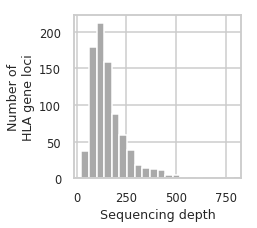

In [30]:
# calculate average depth of immunoid next
run_dir = '/rnd/users/rpyke/data/00-DASH/output/dbGap_02'
dash_directories = os.listdir(run_dir)
dash_output_paths = [F'{run_dir}/{dash_directory}' for dash_directory in dash_directories]

# check these paths all exists
for path in dash_output_paths:
    if not os.path.exists(path):
        print(F"Path: {path} doesn't exist")

# grab DASH.all_positions for A B C & calculate the mean depth
normal_depths = []
tumor_depths = []
for dash_output_path in dash_output_paths:
    gene_files = ['DASH.all_positions_A.csv', 'DASH.all_positions_B.csv', 'DASH.all_positions_C.csv']
    
    for gene_file in gene_files:
        alleles = [1, 2]
        try:
            depth_df = pd.read_csv(F'{dash_output_path}/{gene_file}')
            for allele in alleles:
                depth_normal = statistics.mean(list(depth_df[F'coverage_normal_{allele}']))
                depth_tumor = statistics.mean(list(depth_df[F'coverage_tumor_{allele}']))
                normal_depths.append(depth_normal)
                tumor_depths.append(depth_tumor)
        except Exception as e:
            pass

print(np.mean(tumor_depths), np.median(tumor_depths))
            

plt.figure(figsize=(3, 3))
sns.set_context('talk', font_scale=0.7)

pd.Series(tumor_depths).hist(bins=20, color='darkgrey')
plt.xlabel('Sequencing depth')
plt.ylabel('Number of\nHLA gene loci')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/downsampling.Standard_exome_coverage_histogram.pdf', 
            bbox_inches='tight')

In [31]:
pd.Series(tumor_depths).describe()

count    842.000000
mean     161.059979
std       93.661363
min       24.443343
25%       97.962577
50%      136.904582
75%      190.928813
max      786.505184
dtype: float64